# Modeling a pandemic using network theory


## Overview

- **Traditional modelling (SIR)**
- **Network-specific modelling (Gillespie)**

In this notebook we will have a look at traditional epidemic models and their network counterpart. We will in the end explore aspects and strategies of immunization. 

Large parts of this notebook is adopted from [Andrew Atkeson](https://sites.google.com/site/andyatkeson/) and [je-suis-TM](https://je-suis-tm.github.io/graph-theory/epidemic-outbreak/).

For more, see:
- [NBER Working Paper No. 26867](https://www.nber.org/papers/w26867)  
- [COVID-19 Working papers and code](https://sites.google.com/site/andyatkeson/home?authuser=0)  

In [1]:
import numpy as np
from numpy import exp
from pathlib import Path
import matplotlib.pyplot as plt

# the SIR-model is solved with ordinary differential equations
from scipy.integrate import odeint 

## The SIR Model

<img src="assets/SIR_graph.png">

We will use a slightly modified version, with 4 instead of 3 states.

All individuals in the population are assumed to be in one of these four states.

The states are: susceptible (S), exposed (E), infected (I) and recovered (R).

Comments:

- Those in state R have been infected and either recovered or died.  
- Those who have recovered are assumed to have acquired immunity.  
- Those in the exposed group are not yet infectious.

### Time Path

The flow across states follows the path $ S \to E \to I \to R $.

All individuals in the population are eventually infected when
the transmission rate is positive and $ i(0) > 0 $.

The interest is primarily in

- the number of infections at a given time (which determines whether or not the health care system is overwhelmed) and  
- how long the caseload can be deferred (hopefully until a vaccine arrives)  


Using lower case letters for the fraction of the population in each state, the
dynamics are


<a id='equation-sir-system'></a>
$$
\begin{aligned}
     \dot s(t)  & = - \beta(t) \, s(t) \,  i(t)
     \\
     \dot e(t)  & = \beta(t) \,  s(t) \,  i(t)  - σ e(t)
     \\
     \dot i(t)  & = σ e(t)  - γ i(t)
\end{aligned} \tag{1}
$$

In these equations,

- $ \beta(t) $ is called the *transmission rate* (the rate at which individuals bump into others and expose them to the virus).  
- $ \sigma $ is called the *infection rate* (the rate at which those who are exposed become infected)  
- $ \gamma $ is called the *recovery rate* (the rate at which infected people recover or die).  
- the dot symbol $ \dot y $ represents the time derivative $ dy/dt $.  


We do not need to model the fraction $ r $ of the population in state $ R $ separately because the states form a partition.

In particular, the “removed” fraction of the population is $ r = 1 - s - e - i $.

We will also track $ c = i + r $, which is the cumulative caseload
(i.e., all those who have or have had the infection).

The system [(1)](#equation-sir-system) can be written in vector form as


<a id='equation-dfcv'></a>
$$
\dot x = F(x, t),  \qquad x := (s, e, i) \tag{2}
$$

for suitable definition of $ F $ (see the code below).

### Parameters

Both $ \sigma $ and $ \gamma $ are thought of as fixed, biologically determined parameters.

As in Atkeson’s note, we set

- $ \sigma = 1/5.2 $ to reflect an average incubation period of 5.2 days.  
- $ \gamma = 1/18 $ to match an average illness duration of 18 days.  


The transmission rate is modeled as

- $ \beta(t) := R(t) \gamma $ where $ R(t) $ is the *effective reproduction number* at time $ t $.  


(The notation is slightly confusing, since $ R(t) $ is different to
$ R $, the symbol that represents the removed state.)

## Implementation

First we set the population size to match the US.

In [2]:
pop_size = 3.3e8

Next we fix parameters as described above.

In [3]:
γ = 1 / 18
σ = 1 / 5.2

Now we construct a function that represents $ F $ in [(2)](#equation-dfcv)

In [4]:
def F(x, t, R0=1.6):
    """
    Time derivative of the state vector.

        * x is the state vector (array_like)
        * t is time (scalar)
        * R0 is the effective transmission rate, defaulting to a constant

    """
    s, e, i = x

    # New exposure of susceptibles
    β = R0(t) * γ if callable(R0) else R0 * γ
    ne = β * s * i

    # Time derivatives
    ds = - ne
    de = ne - σ * e
    di = σ * e - γ * i

    return ds, de, di

In [5]:
callable(F)

True

Note that `R0` can be either constant or a given function of time.

The initial conditions are set to

In [6]:
# initial conditions of s, e, i
i_0 = 1e-7
e_0 = 4 * i_0
s_0 = 1 - i_0 - e_0

In vector form the initial condition is

In [7]:
x_0 = s_0, e_0, i_0

We solve for the time path numerically using odeint, at a sequence of dates
`t_vec`.

In [8]:
def solve_path(R0, t_vec, x_init=x_0):
    """
    Solve for i(t) and c(t) via numerical integration,
    given the time path for R0.

    """
    G = lambda x, t: F(x, t, R0)
    s_path, e_path, i_path = odeint(G, x_init, t_vec).transpose()

    c_path = 1 - s_path - e_path       # cumulative cases
    return i_path, c_path

## Experiments

Let’s run some experiments using this code.

The time period we investigate will be 550 days, or around 18 months:

In [9]:
t_length = 950 #550
grid_size = 1000
t_vec = np.linspace(0, t_length, grid_size)

### Experiment 1: Constant R0 Case

Let’s start with the case where `R0` is constant.

We calculate the time path of infected people under different assumptions for `R0`:

In [10]:
R0_vals = np.linspace(.8, 3.0, 6)
labels = [f'$R0 = {r:.2f}$' for r in R0_vals]
i_paths, c_paths = [], []

for r in R0_vals:
    i_path, c_path = solve_path(r, t_vec)
    i_paths.append(i_path)
    c_paths.append(c_path)

Here’s some code to plot the time paths.

In [11]:
def plot_paths(paths, labels, times=t_vec):

    fig, ax = plt.subplots()

    for path, label in zip(paths, labels):
        ax.plot(times, path, label=label)

    ax.legend(loc='upper left')

    plt.show()

Let’s plot current cases as a fraction of the population.

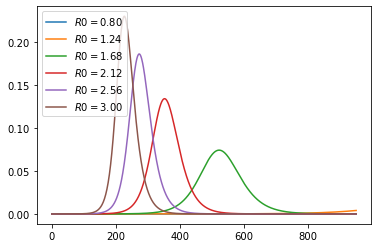

In [12]:
plot_paths(i_paths, labels)

As expected, lower effective transmission rates defer the peak of infections.

They also lead to a lower peak in current cases.

Here is cumulative cases, as a fraction of population:

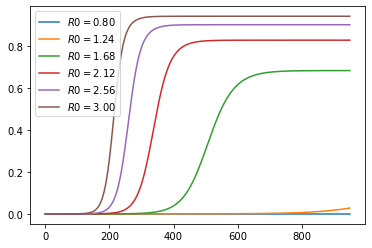

In [13]:
plot_paths(c_paths, labels)

#### Ex. Set R0 to less than 1, and replot the graphs. Explain your observation.

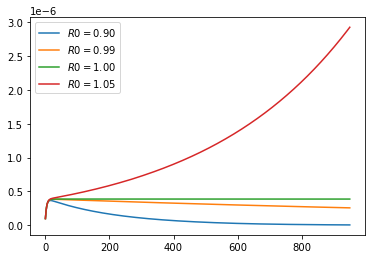

In [14]:
# %load solutions/

R0_vals = [.9, .99, 1., 1.05]
labels = [f'$R0 = {r:.2f}$' for r in R0_vals]
i_paths, c_paths = [], []

for r in R0_vals:
    i_path, c_path = solve_path(r, t_vec)
    i_paths.append(i_path)
    c_paths.append(c_path)

plot_paths(i_paths, labels)

# ANSWER:
# at R=1, the rate at which new people are infected equals the rate at which people recover. 
# Thus there is no net change. R=1 is the tipping point. Below 1, the number drops.

### Experiment 2: Changing Mitigation

Let’s look at a scenario where mitigation (e.g., social distancing) is
successively imposed.

Here’s a specification for `R0` as a function of time.

In [15]:
def R0_mitigating(t, r0=3, η=1, r_bar=1.6):
    R0 = r0 * exp(- η * t) + (1 - exp(- η * t)) * r_bar
    return R0

The idea is that `R0` starts off at 3 and falls to 1.6.

This is due to progressive adoption of stricter mitigation measures.

The parameter `η` controls the rate, or the speed at which restrictions are
imposed.

We consider several different rates:

In [16]:
η_vals = 1/5, 1/10, 1/20, 1/50, 1/100
labels = [fr'$\eta = {η:.2f}$' for η in η_vals]

This is what the time path of `R0` looks like at these alternative rates:

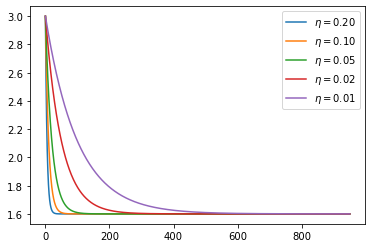

In [17]:
fig, ax = plt.subplots()

for η, label in zip(η_vals, labels):
    ax.plot(t_vec, R0_mitigating(t_vec, η=η), label=label)

ax.legend()
plt.show()

Let’s calculate the time path of infected people:

In [18]:
i_paths, c_paths = [], []

for η in η_vals:
    R0 = lambda t: R0_mitigating(t, η=η)
    i_path, c_path = solve_path(R0, t_vec)
    i_paths.append(i_path)
    c_paths.append(c_path)

This is current cases under the different scenarios:

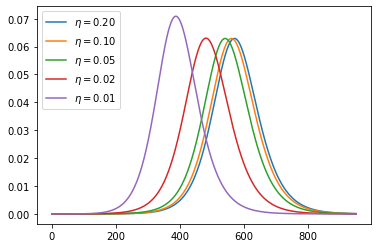

In [19]:
plot_paths(i_paths, labels)

Here are cumulative cases, as a fraction of population:

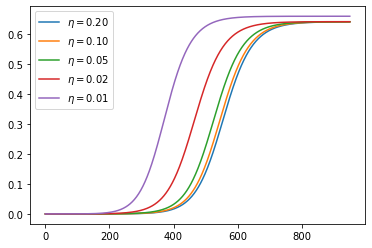

In [20]:
plot_paths(c_paths, labels)

## Ending Lockdown

The following replicates [additional results](https://drive.google.com/file/d/1uS7n-7zq5gfSgrL3S0HByExmpq4Bn3oh/view) by Andrew Atkeson on the timing of lifting lockdown.

Consider these two mitigation scenarios:

1. $ R_t = 0.5 $ for 30 days and then $ R_t = 2 $ for the remaining 17 months. This corresponds to lifting lockdown in 30 days.  
1. $ R_t = 0.5 $ for 120 days and then $ R_t = 2 $ for the remaining 14 months. This corresponds to lifting lockdown in 4 months.  


The parameters considered here start the model with 25,000 active infections
and 75,000 agents already exposed to the virus and thus soon to be contagious.

In [21]:
# initial conditions
i_0 = 25_000 / pop_size
e_0 = 75_000 / pop_size
s_0 = 1 - i_0 - e_0
x_0 = s_0, e_0, i_0

Let’s calculate the paths:

In [22]:
R0_paths = (lambda t: 0.5 if t < 30 else 2,
            lambda t: 0.5 if t < 120 else 2)

labels = [f'scenario {i}' for i in (1, 2)]

i_paths, c_paths = [], []

for R0 in R0_paths:
    i_path, c_path = solve_path(R0, t_vec, x_init=x_0)
    i_paths.append(i_path)
    c_paths.append(c_path)

Here is the number of active infections:

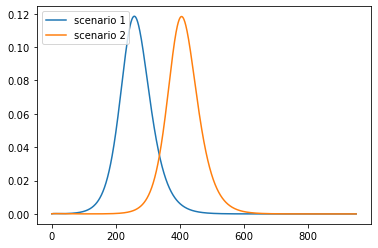

In [23]:
plot_paths(i_paths, labels)

What kind of mortality can we expect under these scenarios?

Suppose that 1% of cases result in death

In [24]:
ν = 0.01

This is the cumulative number of deaths:

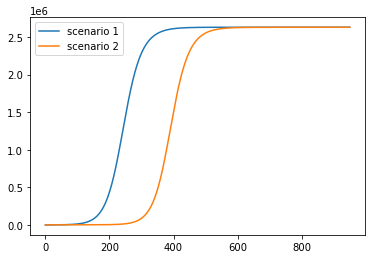

In [25]:
paths = [path * ν * pop_size for path in c_paths]
plot_paths(paths, labels)

This is the daily death rate:

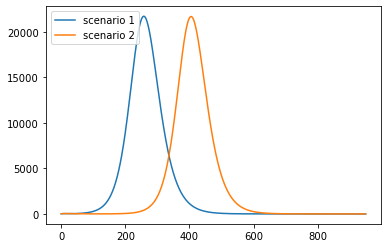

In [26]:
paths = [path * ν * γ * pop_size for path in i_paths]
plot_paths(paths, labels)

Pushing the peak of curve further into the future may reduce cumulative deaths
if a vaccine is found.

# A network SIR model

The drawback of the above model is that is it completely blind to network structure, assuming random mixing: every person is equally likely to interact. Above, the only parameters specified were the population size, and the number of individuals in each state. Knowing only the slighest about social networks, this assumption can surely be discarded. To explain why and model how certain demographics are more infected than others, we need to take network structure into account.


### The Gillespie algorithm
This method draws on the power of stochastic modelling (Monte Carlo), and does not require any difficult mathematics. Like in the SIR-model, each node has three states (susceptible-infected-recovered). It is an iterative algorithm. At each step, there is a certain probability of transmission between any two nodes adjacent in the system.


#### Credit to Github user je-suis-tm for the code.

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import imageio
import copy
import pandas as pd
import numba
import os

In [13]:
#simulate status change of each agent
#in order to boost the performance of the algorithm
#we can only use one package, numpy
#the code itself may look obselete
#because only a few numpy functions are supported in numba
#details are in the following link
# http://numba.pydata.org/numba-doc/dev/reference/numpysupported.html

# Note: R0 here is the number recovered, not referring to the transimission rate.

@numba.jit(nopython=True)
def gillespie(adjmatrix,param,p0):
    
    #unpack
    tmax,t,infection_rate,recovery_rate,S0,I0,R0=param
    
    #initial
    n_S=S0
    n_I=I0
    n_R=R0
    list_S,list_I,list_R=[S0],[I0],[R0]
    
    #create status of each agent
    #0 denotes susceptible
    #1 denotes infected
    #-1 denotes recovered
    
    
    status = np.zeros(shape=adjmatrix.shape[0])
    status[p0] = 1
    
   #status=np.array([0]*S0+[1]*I0+[-1]*R0)
   #np.random.shuffle(status)
    
    list_t=[0]
    
    #de facto deep copy
    list_status=[i for i in status]

    #unless every patient is recovered
    #or t has reach the maximum elapsed time
    #nothing is gonna stop us now
    while t<tmax:
        if n_I==0:
            break
        
        #compute propensity
        propensity1=infection_rate*n_S*n_I 
        propensity2=recovery_rate*n_I
        propensity_all=propensity1+propensity2
        
        #tau leaping
        tau=-np.log(np.random.rand())/propensity_all
        t=t+tau

        currently_infected=np.array([i for i in range(adjmatrix.shape[0]) if status[i]==1])
        
        if np.random.rand()<propensity1/propensity_all:

            #if people around susceptible cannot spread disease
            #we have to terminate the infection
            #otherwise we stuck in infinitive loops
            currently_susceptible=[i for i in range(adjmatrix.shape[0]) if status[i]==0]
            
            #this part looks confusing
            #it is equivalent to [status[j] for i in currently_susceptible for j in graph.neighbors(i)]
            neighbor_status=[status[j] for i in currently_susceptible for j in [ii for ii in range(adjmatrix.shape[0]) if adjmatrix[ii][i]==1]]
            if (neighbor_status).count(1)==0:
                continue

            #randomly select an infected patient
            #randomly select one of her/his susceptible connections
            #infect that poor soul
            stop=False
            while not stop:
                selected=np.random.choice(currently_infected,1)[0]
                
                #this part looks confusing
                #it is equivalent to [i for i in graph.neighbors(selected) if status[i]==0]     
                connections=np.array([i for i in [ii for ii in range(adjmatrix.shape[0]) if adjmatrix[ii][selected]==1] if status[i]==0])
                if connections.shape!=(0,):
                    new_infected=np.random.choice(connections,1)[0]
                    stop=True

            #update data
            status[new_infected]=1        
            n_S=n_S-1
            n_I=n_I+1
            
        else:

            #cure a random infected patient
            selected=np.random.choice(currently_infected,1)[0]

            #update data
            status[selected]=-1        
            n_I=n_I-1
            n_R=n_R+1

        #update data
        list_S.append(n_S)
        list_I.append(n_I)
        list_R.append(n_R)
        list_t.append(t)
        
        #numba doesnt support nested list
        #thus, we need to improvise
        list_status+=[i for i in status]
        
    return list_t,list_status,list_S,list_I,list_R

In [14]:
#create dataframe for visualization
def create_data(graph,list_t,matrix_status,colorlist):
    
    #unpack
    recovered_color,susceptible_color,infected_color=colorlist
    
    #create dataframe
    data=pd.DataFrame(index=graph.nodes,columns=list_t)
    for i in range(len(data.columns)):
        data[data.columns[i]]=matrix_status[i]
    
    #cleanup
    df=data.T
    df.reset_index(inplace=True)
    
    #discrete time rounding
    df['time']=df['index'].apply(int).diff(-1)
    df.at[0,'time']=-1
    df.at[len(df)-1,'time']=-1
    df=df.loc[df[df['time']!=0].index]
    df['real time']=df['index'].apply(lambda x:int(x)+1)
    df.at[0,'real time']=0
    
    #cleanup
    del df['index']
    del df['time']    
    df.set_index('real time',inplace=True)
    df=df.T
        
    return df

In [15]:
#visualize agent-based model

# zeropadding convenience
zp = lambda num,k: "0"*(k-len(str(num))) + str(num)

def plot_graph(df,graph,colorlist,layout=nx.kamada_kawai_layout, save_gif=False):
    
    #unpack
    recovered_color,susceptible_color,infected_color=colorlist
    
    #fix positions
    #pos=nx.spring_layout(graph)
    pos=layout(graph)
    
    #everytime there is a status change
    #we visualize it
    for i in df.columns:
        plt.title(f't={i}')
        
        #replace value with color
        nx.draw(graph,pos,node_color=df[i].replace({-1:recovered_color,
                                                   0:susceptible_color,
                                                   1:infected_color}))
        
        #create legends
        S=mlines.Line2D([],[],color=susceptible_color,
                                  marker='o',markersize=10,
                                  linewidth=0,label='Susceptible')
        I=mlines.Line2D([],[],color=infected_color,
                                  marker='o',markersize=10,
                                  linewidth=0,label='Infected')
        R=mlines.Line2D([],[],color=recovered_color,
                                  marker='o',markersize=10,
                                  linewidth=0,label='Recovered')
        plt.legend(handles=[S,I,R],loc=0)
        
        if save_gif:
            plt.savefig(f't{zp(i,3)}.png')
        plt.show()
    
    #create gif
    if save_gif:
        
        filenames=["t%s.png" % (zp(ii,3)) for ii in df.columns]
        images=list(map(lambda filename:imageio.imread(filename),
                        filenames))
        outname = 'movie_0'
        while Path(outname+'.gif').exists():
            _, k = outname.split('_')
            outname = f"movie_{int(k)+1}"
        imageio.mimsave(outname+'.gif',images,duration=0.5)

In [16]:
# SET PARAMETERS

#maximum elapsed time
tmax=50

#beginning time
t=0

#initial
infection_rate=0.01
recovery_rate=0.06
S0=49
I0=1
R0=0
N=S0+I0+R0

#data preparation
param=(tmax,t,infection_rate,recovery_rate,S0,I0,R0)
colorlist=['#99B898','#FECEAB','#FF847C']

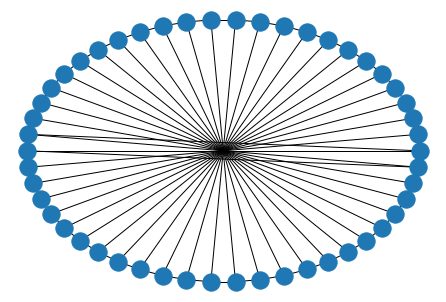

In [17]:
G = nx.circular_ladder_graph((S0+I0+R0)//2)
pos = nx.layout.bipartite_layout(G, nodes=np.arange(0,50, 2))
#nx.layout.bipartite_layout
pos = nx.layout.shell_layout(G)
nx.draw(G, pos=pos)

In [18]:
def simulate(G, tmax=50, p0=None, plot=True, save_fig=True):
    
    #maximum elapsed time
    tmax=tmax    
    #beginning time
    t=0
    #initial
    N = G.number_of_nodes()
    infection_rate=0.01
    recovery_rate=0.06
    I0=1
    S0=N-I0
    R0=0
    
    if not p0: p0 = np.random.choice(N)
    
    #data preparation
    param=(tmax,t,infection_rate,recovery_rate,S0,I0,R0)
    colorlist=['#99B898','#FECEAB','#FF847C']
    adjmatrix=nx.to_numpy_array(G)    
        
    list_t,list_status,_,_,_=gillespie(adjmatrix,param, p0)
    matrix_status=[list_status[i:i+N] for i in range(0,len(list_status),N)]
    df=create_data(G,list_t,matrix_status,colorlist)
    if plot:
        plot_graph(df,G,colorlist, save_gif=save_fig)
    
    return df

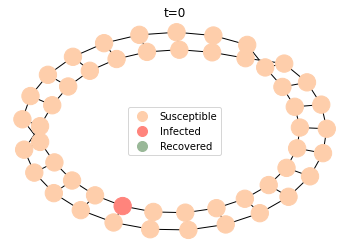

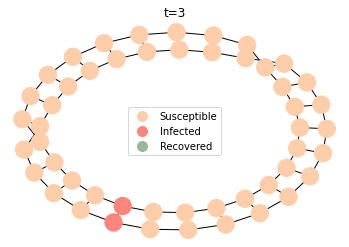

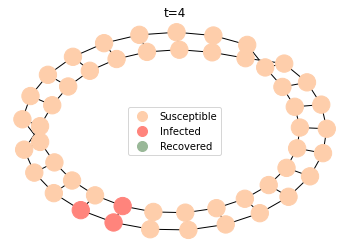

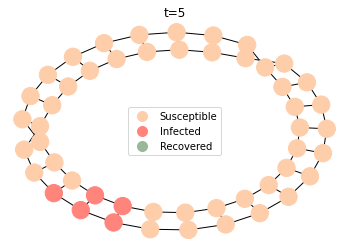

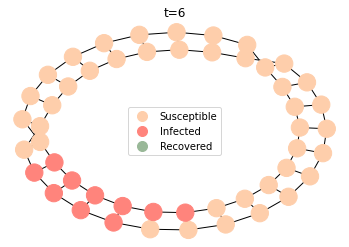

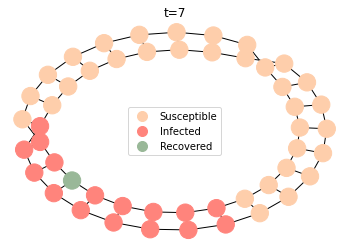

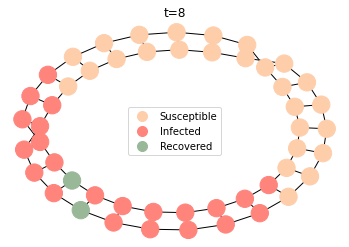

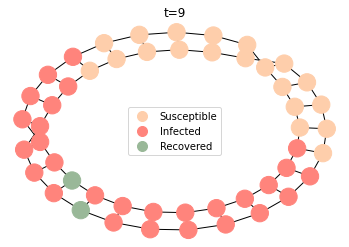

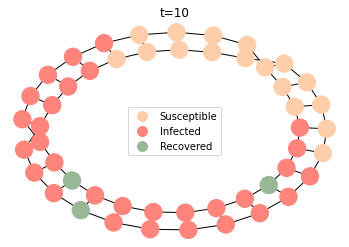

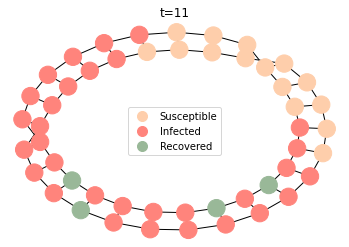

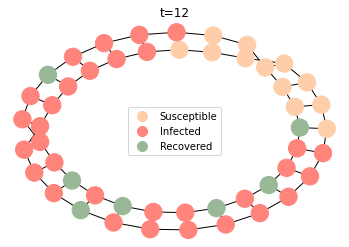

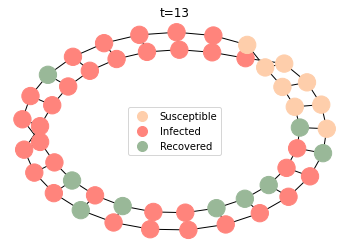

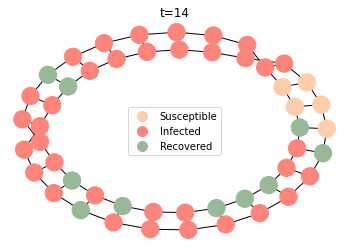

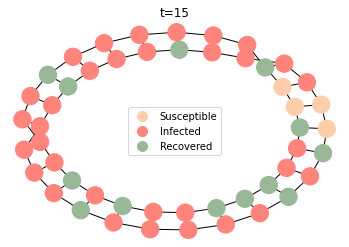

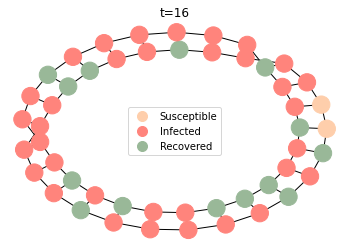

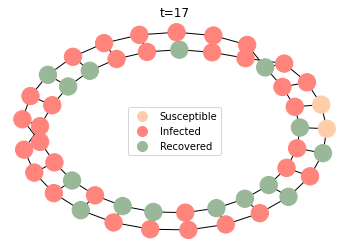

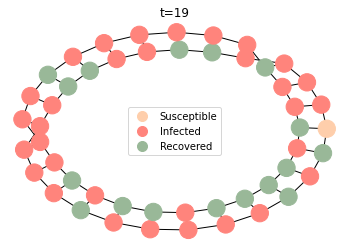

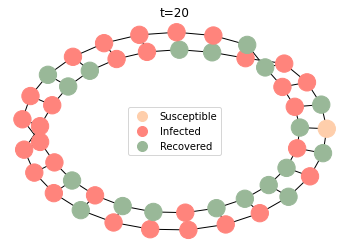

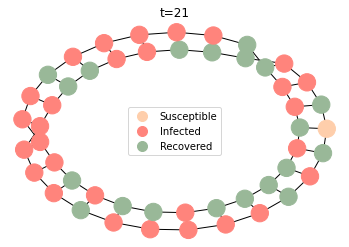

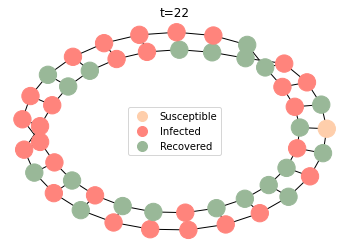

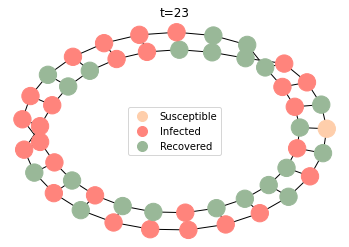

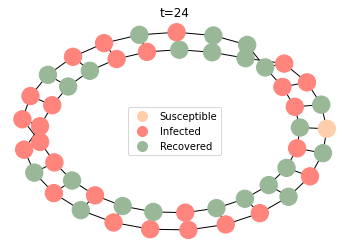

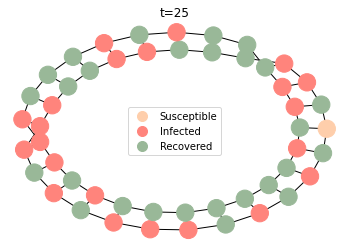

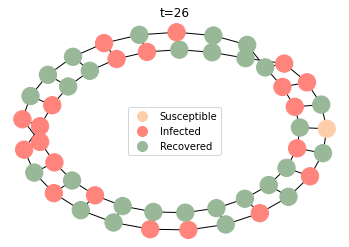

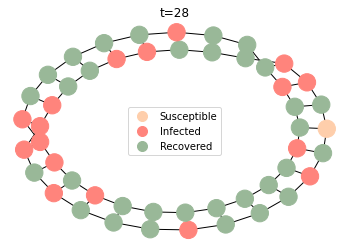

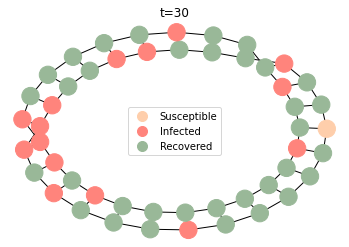

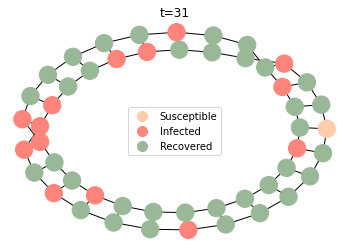

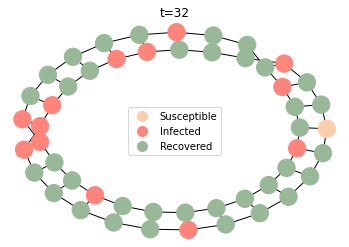

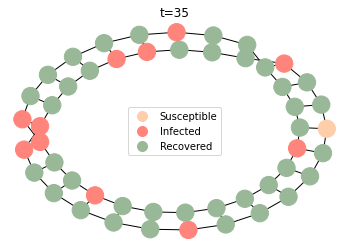

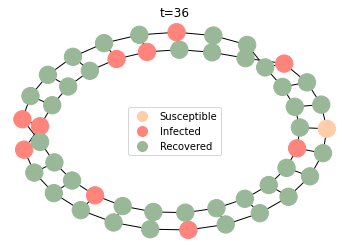

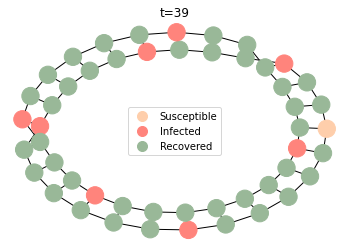

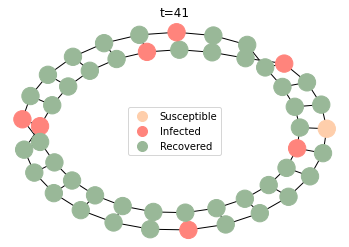

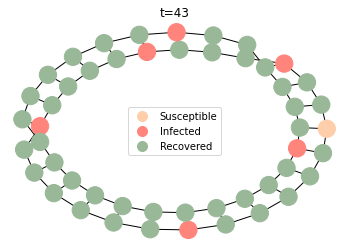

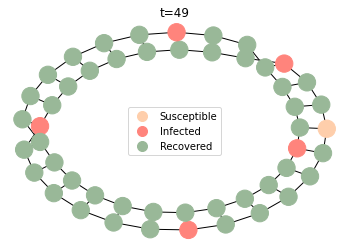

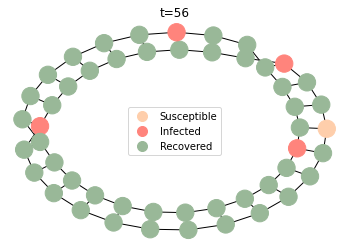

real time,0,3,4,5,6,7,8,9,10,11,...,30,31,32,35,36,39,41,43,49,56
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,0.0,0.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
6,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
7,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0
8,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [35]:
simulate(G,save_fig=False)

## Watch as the disease spreads

We can embed GIFs in jupyter notebooks with html notation: `<img src="movie_0.gif">`

<img src="movie_0.gif">

#### Try with a real network architecture

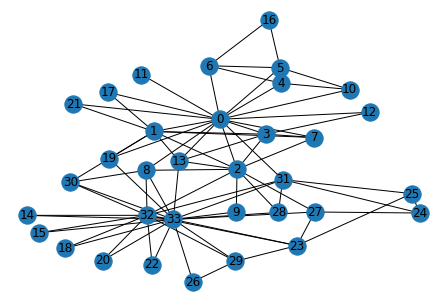

In [19]:
G = nx.karate_club_graph()
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos=pos, with_labels=True)

## Super spreaders
#### Ex. Model disease spread if you infect a network hub.

In [20]:
G.degree

DegreeView({0: 16, 1: 9, 2: 10, 3: 6, 4: 3, 5: 4, 6: 4, 7: 4, 8: 5, 9: 2, 10: 3, 11: 1, 12: 2, 13: 5, 14: 2, 15: 2, 16: 2, 17: 2, 18: 2, 19: 3, 20: 2, 21: 2, 22: 2, 23: 5, 24: 3, 25: 3, 26: 2, 27: 4, 28: 3, 29: 4, 30: 4, 31: 6, 32: 12, 33: 17})

In [21]:
def sort_by_degree(G):
    return sorted(G.degree(), key=lambda x:x[1], reverse=True)

print(sort_by_degree(G)[:5])
print(sort_by_degree(G)[-5:])

[(33, 17), (0, 16), (32, 12), (2, 10), (1, 9)]
[(20, 2), (21, 2), (22, 2), (26, 2), (11, 1)]


Text(0.5, 1.0, 'Patient zero is a hub')

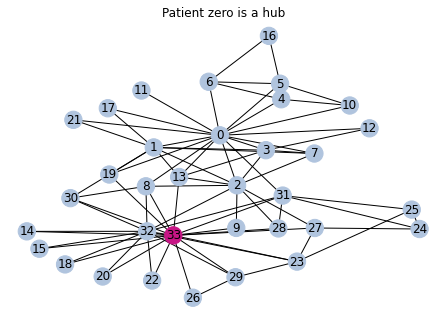

In [22]:
def highlight_node(G, node):
    cmap = ['lightsteelblue']*G.number_of_nodes()
    cmap[node] = 'mediumvioletred'
    nx.draw(G, node_color=cmap, pos=pos, with_labels=True)
    
highlight_node(G,33)
plt.title('Patient zero is a hub')

Text(0.5, 1.0, 'Patient zero is peripheral')

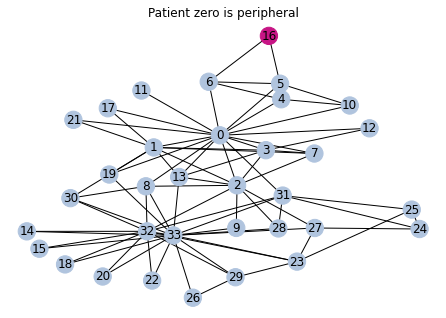

In [23]:
highlight_node(G,16)
plt.title('Patient zero is peripheral')

In [24]:
adjmatrix = nx.to_numpy_array(G)
pos = nx.kamada_kawai_layout(G)

In [25]:
# Patient zero is central
p0 = 33

df = simulate(G, tmax=100, p0=p0, plot=False)

df[df==-1.0] = 0
p0_33x = df.columns
p0_33y = df.values.sum(0)

In [26]:
# Patient zero is a hub
p0 = 16

df = simulate(G, tmax=100, p0=p0, plot=False)

df[df==-1.0] = 0
p0_16x = df.columns 
p0_16y = df.values.sum(0)

### Compare spread 
<img src="movie_1.gif" style="float:left" width="400">
<img src="movie_2.gif" style="float:center" width="400">

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(p0_33x, p0_33y, label='hub first')
plt.plot(p0_16x, p0_16y, label='peripheral first')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Number infected')
plt.title('Effect of patient zero')

What do you observe? Perhaps you will have to run the code above multiple times to see the pattern due to the stochastic nature of the algorithm. Hint: comment out the line with `plot_graph` to make them run faster.

### Disease spread in a larger network

In [52]:
G = nx.erdos_renyi_graph(200, 10/250)
adjmatrix = nx.to_numpy_array(G)
pos = nx.kamada_kawai_layout(G)
N = G.number_of_nodes()
t_max = 500

#p0 = np.random.choice(G.number_of_nodes())
degrees_srt = sorted(nx.betweenness_centrality(G).items(), key=lambda n:n[1], reverse=True)

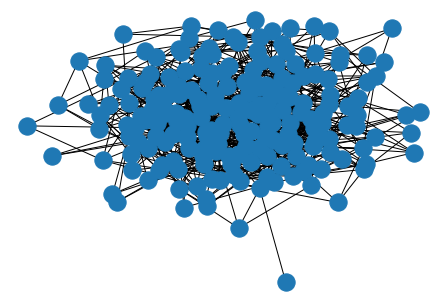

In [53]:
nx.draw(G)

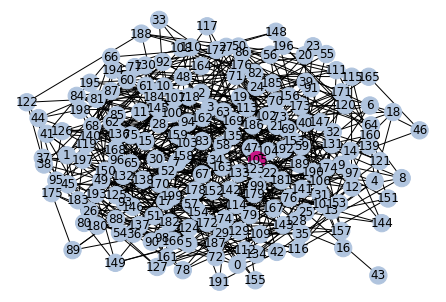

In [54]:
highlight_node(G,degrees_srt[0][0])

In [55]:

# High degree
p0 = degrees_srt[0][0]

df = simulate(G, tmax=tmax, p0=p0, plot=False)


df[df==-1.0] = 0
p0_hubx = df.columns 
p0_huby = df.values.sum(0)

In [56]:
# Peripheral
p0 = degrees_srt[-1][0]

df = simulate(G, tmax=100, p0=p0, plot=False)

df[df==-1.0] = 0
p0_perx = df.columns 
p0_pery = df.values.sum(0)

Text(0.5, 1.0, 'Effect of patient zero')

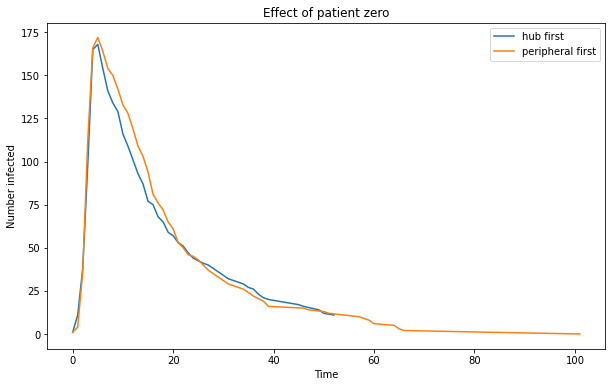

In [57]:
plt.figure(figsize=(10,6))
plt.plot(p0_hubx, p0_huby, label='hub first')
plt.plot(p0_perx, p0_pery, label='peripheral first')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Number infected')
plt.title('Effect of patient zero')

After many simulations, it appears that the topological position of patient zero is irrelevant to the time it takes for the curve to peak. This may seem surprising, but on the other hand, this is not surprising considering the small-world property of many networks. The take-home lesson is that information can travel very rapidly across a network, regardless of your starting point.

You may be excused from thinking that this means that hubs are no more important than peripheral nodes. To gain insight on the importance of nodes, we turn to the next section.

## Network percolation and vaccination strategies

On the topic of network robustness, we can judge a network's resistance to failure by removing either nodes or edges (percolation). This topic has been studied with regards to comparing different network architectures to develop robust networks, such as the internet. In the context of disease prevention, we rather want a *unrobust* network, which translates to hindering the flow of the disease-causing agent. On top of that we can also look into *who* we should vaccinate for optimal immunity.

In [58]:
def random_strat(G):
    """
    Inputs 
    G : the nx.Graph
    Returns the ordered list or array of nodes to vaccinate, from most to least important
    """
    # Your code here
    N = G.number_of_nodes()
    return np.random.choice(range(N), N, replace=False)
    
    
def evaluate_strategy(vax_strat, G):
    H = G.copy()
    immunized_nodes = vax_strat(H)
    # remove nodes from network
    
    S = []
    for node in immunized_nodes[:-1]:
        H.remove_node(node)
        # identify largest connected component (Giant component)
        Hcc = sorted(nx.connected_components(H), key=len, reverse=True)
        S.append(len(Hcc[0]))
    return S 
    

#### Exercise: define a strategy to beat the random strategy

In [59]:
# %load solutions/...
def vax_strat(G):
    """
    Inputs 
    G : the nx.Graph
    Returns the ordered list or array of nodes to vaccinate, from most to least important
    """
    return np.array(sorted(G.degree, key=lambda n:n[1], reverse=True))[:, 0]
    

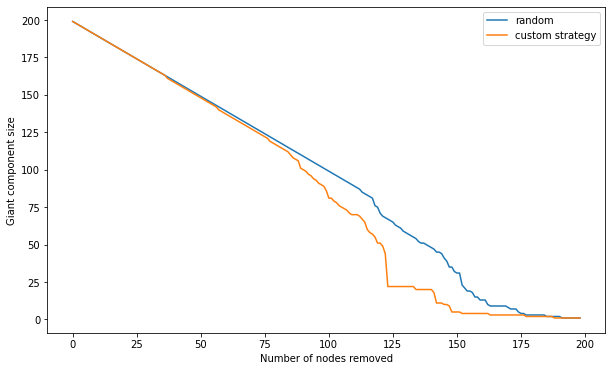

In [63]:
xs = range(G.number_of_nodes())[:-1]
ys = evaluate_strategy(random_strat, G)

plt.figure(figsize=(10,6))
plt.plot(xs,ys, label='random')

ys = evaluate_strategy(vax_strat, G)
plt.plot(xs,ys, label='custom strategy')

plt.ylabel('Giant component size')
plt.xlabel('Number of nodes removed')

plt.legend()

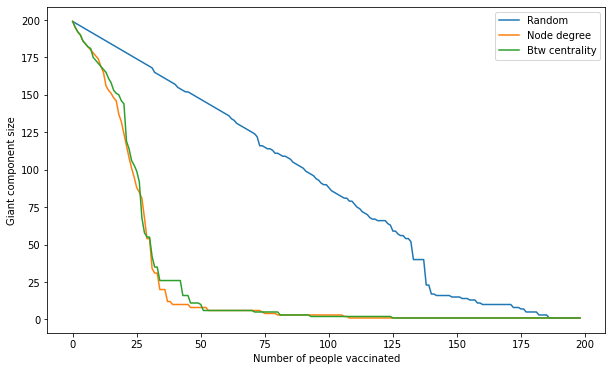

In [64]:
# How about in a scale-free network
G = nx.barabasi_albert_graph(200, 2, seed=None)

def vax_btw(G):
    """
    Inputs 
    G : the nx.Graph
    Returns the ordered list or array of nodes to vaccinate, from most to least important
    """
    # Your code here
    return np.array(sorted(nx.betweenness_centrality(G).items(), key=lambda n:n[1], reverse=True))[:, 0]

xs = range(G.number_of_nodes())[:-1]
ys = ys = evaluate_strategy(random_strat, G)

plt.figure(figsize=(10,6))
plt.plot(xs,ys, label='Random')
plt.ylabel('Giant component size')
plt.xlabel('Number of people vaccinated')

ys = evaluate_strategy(vax_strat, G)
plt.plot(xs,ys, label='Node degree')

ys = evaluate_strategy(vax_btw, G)
plt.plot(xs,ys, label='Btw centrality')

plt.legend()

#### Exercise: Redo the calculation but recalculate the degree centrality at each iteration. Compare it to when you only calculate it once.

In [121]:
# your code here

In [101]:
def make_plot(G):
    xs = range(G.number_of_nodes())[:-1]
    ys = evaluate_strategy(random_strat, G)

    plt.figure(figsize=(10,6))
    plt.plot(xs,ys, label='Random')
    plt.ylabel('Giant component size')
    plt.xlabel('Number of people vaccinated')
    
    ys = evaluate_strategy(vax_strat, G)
    plt.plot(xs,ys, label='Node degree')    
    plt.legend()
    plt.title(G.name)

### Your turn: apply the above strategies to a attack non-scalefree networks, such as an Erdös-Reniy graph. 
Make a plot like the one above and compare how scale vs scale-free networks behave.

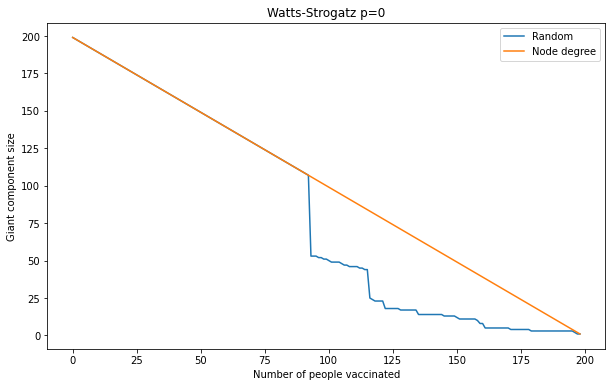

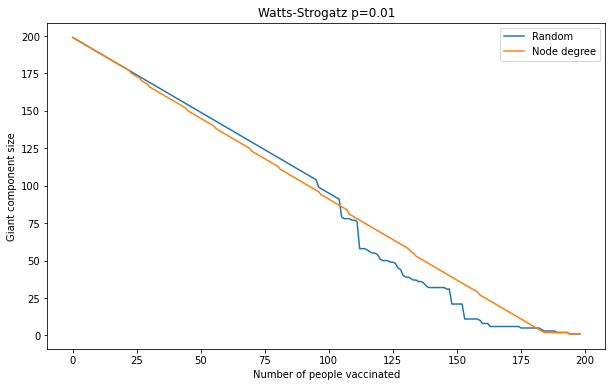

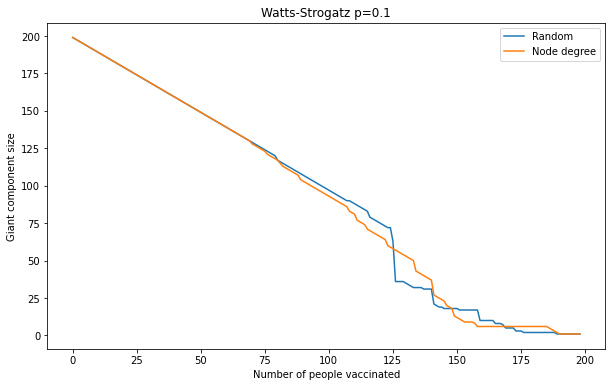

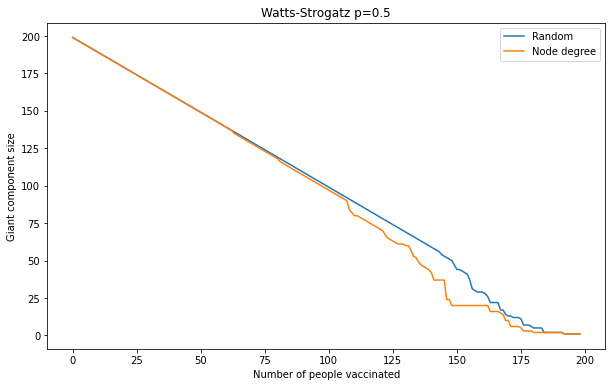

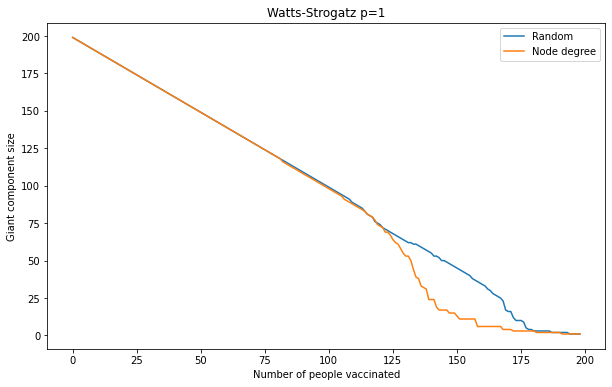

In [161]:
### YOUR CODE HERE

for p in [0, 0.01, 0.1, 0.5, 1]:
    G = nx.watts_strogatz_graph(200, 10, p); G.name = f"Watts-Strogatz p={p}"
    make_plot(G)


On a population scale, any country would be a highly modular network - each module representing a city. The connections between these modules/cities, i.e. commuters, would be of special interest.

While not explicitly a network model, the models of FHI use this important information of commuting.
https://folkehelseinstituttet.github.io/spread/articles/commuter_model.html

In [159]:
## IGNORE

#import math
#
#import matplotlib.pyplot as plt
#import networkx as nx
#
## This example needs Graphviz and either PyGraphviz or pydot.
## from networkx.drawing.nx_pydot import graphviz_layout as layout
#
## If you don't have pygraphviz or pydot, you can do this
#layout = nx.spring_layout
#
#
#n = 50  # 150 nodes
## p value at which giant component (of size log(n) nodes) is expected
#p_giant = 1.0 / (n - 1)
## p value at which graph is expected to become completely connected
#p_conn = math.log(n) / float(n)
#
## the following range of p values should be close to the threshold
#pvals = [0.003, 0.006, 0.008, 0.015]
#
#region = 220  # for pylab 2x2 subplot layout
##plt.figure(figsize=(10,10))
##plt.subplots_adjust(left=0, right=1, bottom=0, top=0.95, wspace=0.01, hspace=0.01)
#
#
## init pos
#G = nx.binomial_graph(20, 0.2)
#pos = layout(G)
#
#H = G.copy()
#
#nodes_to_remove = [n for n in H.nodes()]
#
#for ii, node in enumerate(nodes_to_remove):
#    # remove nodes from network
#    nx.draw_networkx_nodes(H, pos, node_size=10)
#
#    H.remove_node(node)
#    # identify largest connected component (Giant component)
#    Hcc = sorted(nx.connected_components(H), key=len, reverse=True)
#    H0 = H.subgraph(Hcc[0])
#    nx.draw_networkx_edges(H0, pos, edge_color="r", width=2.0)
#    plt.savefig(f"perc_{node}.jpg")
#    plt.show()
#
#    
#   # for Gi in Gcc[1:]:
#   #     if len(Gi) > 1:
#   #         nx.draw_networkx_edges(G.subgraph(Gi), pos, edge_color="r", alpha=0.3, width=5.0)
#
#        
#    
#
#
#
##
##for p in pvals:
##    G = nx.binomial_graph(n, p)
##    pos = layout(G)
##    region += 1
##    plt.subplot(region)
##    plt.title(f"p = {p:.3f}")
##    nx.draw(G, pos, with_labels=False, node_size=10)
##    # identify largest connected component
##    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
##    G0 = G.subgraph(Gcc[0])
##    nx.draw_networkx_edges(G0, pos, edge_color="r", width=6.0)
##    # show other connected components
##    for Gi in Gcc[1:]:
##        if len(Gi) > 1:
##            nx.draw_networkx_edges(
##                G.subgraph(Gi), pos, edge_color="r", alpha=0.3, width=5.0,
##            )
##plt.show()

## Bonus: when network structure is unknown
It is no surprise that this pandemic network has not been mapped, and is inherently difficult to map as it is changing over time, not to speak of the privacy issues that would arise if we did attempt to map it. This does not however, mean that we must surrender back to random vaccination. 

#### Acquaintance immunization
Counter-intuitively, we can beat random chance vaccinations using the following simple strategy: choose a random person from the yellow pages, and let them nominate (at random) one of their acquaintances. Vaccinate that acquaintance.

This sounds strange, but actually we exploit a well-known result in social network science: on average your friends have more friends than you. The intuition is that by virtue of the definition of a hub (participating in a disproportionately large number of edges), there will be a bias for *your* edges to also connect to these hubs. (Imagine selecting a random edge in the network, then arbitrarily selecting one of its nodes. Your are more likely to land on a hub than on a peripheral node).

### Exercise: Explore the friendship paradox from a synthetic.

Calculate the average degree, then compare it to the average neighbor degree in the network.

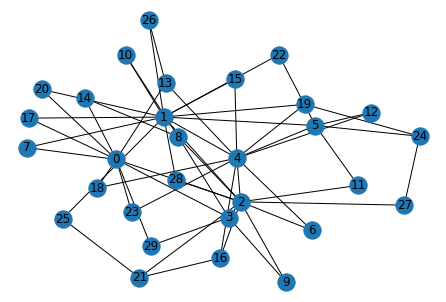

In [3]:
G = nx.generators.random_graphs.barabasi_albert_graph(30,  2, seed=42)
nx.draw(G, with_labels=True)

In [4]:
# %load solutions/...
# Average degree
average_degree = sum([G.degree(v) for v in G.nodes()]) / G.number_of_nodes()

# Equivalent:
#2*G.number_of_edges() / G.number_of_nodes()

# average degree of neighbors:
nbtot = 0
for v in G.nodes():
    v_deg = G.degree(v)
    nbtot += sum([G.degree(nb) for nb in G.neighbors(v)]) / v_deg
average_neighbor_degree = nbtot / G.number_of_nodes()

print(f'Average degree: {average_degree}\nAverage neighbor\'s degree: {average_neighbor_degree}')

Average degree: 3.7333333333333334
Average neighbor's degree: 8.054164724164725


## Comparing three strategies

We can easily simulate this strategy and visualize how the network fragments.

The code below (credit to [eflagara](https://github.com/eflegara/Network-Science-Lectures/blob/master/Vaccination%20Strategies.ipynb)) shows how acquaintance immunization performs in between random chance and the best(*) strategy: targeting hubs.

(*)
Actually there exist another method that is based on a different framework: fragmenting network modules by targeting bridging nodes.

RESULTS AFTER VACCINATING 50.0% OF THE POPULATION


Text(0.5, 1.0, 'ACQUAINTANCE IMMUNIZATION')

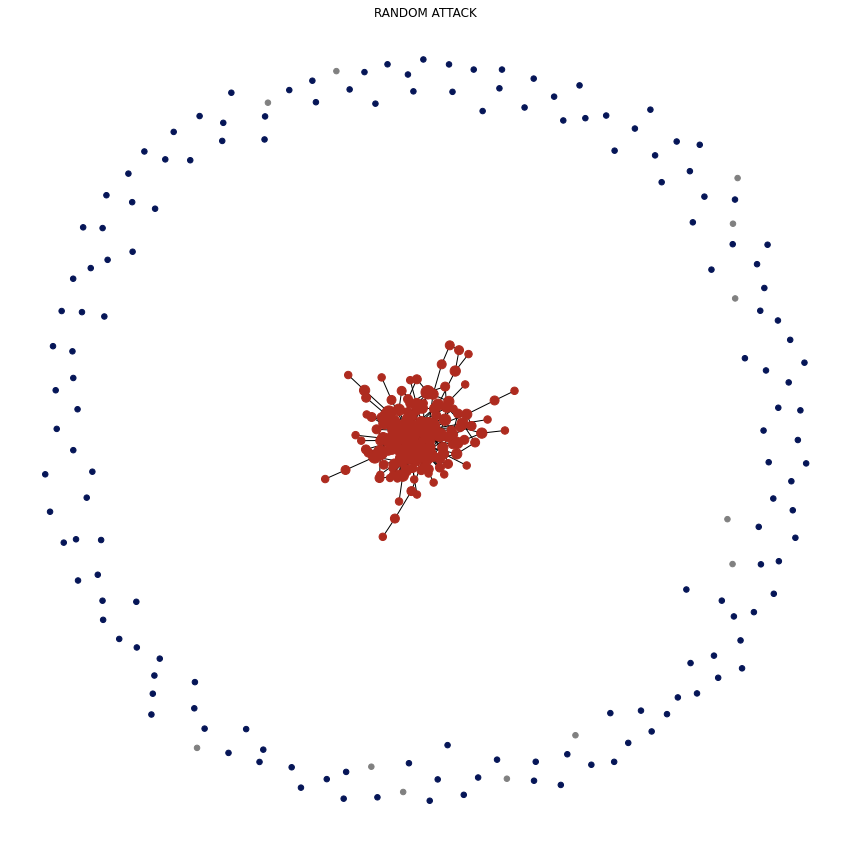

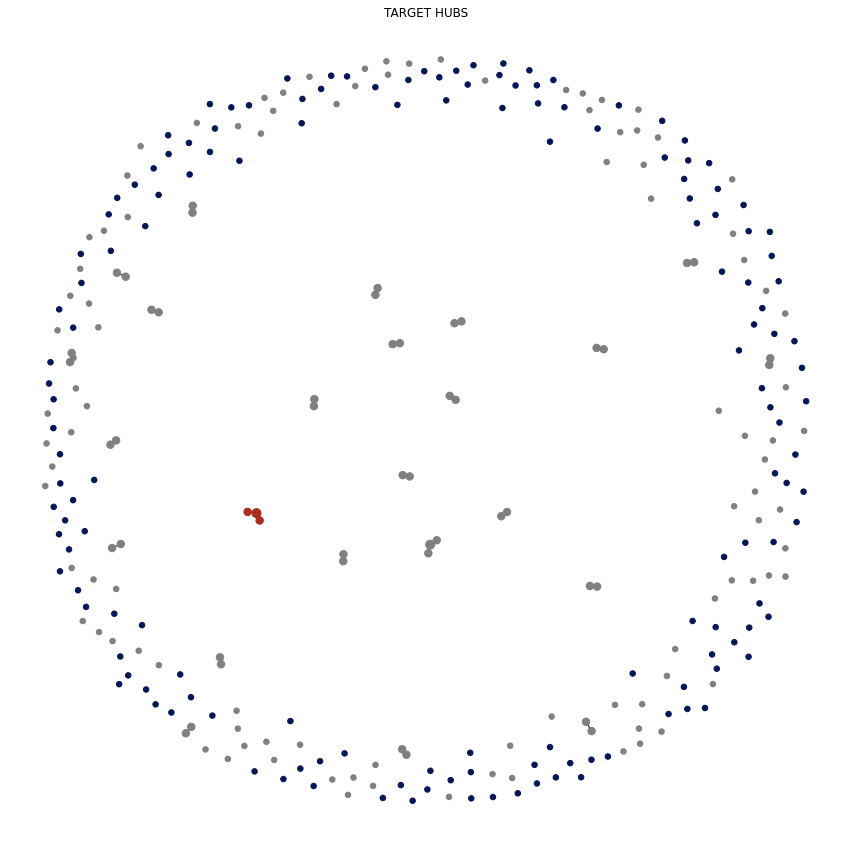

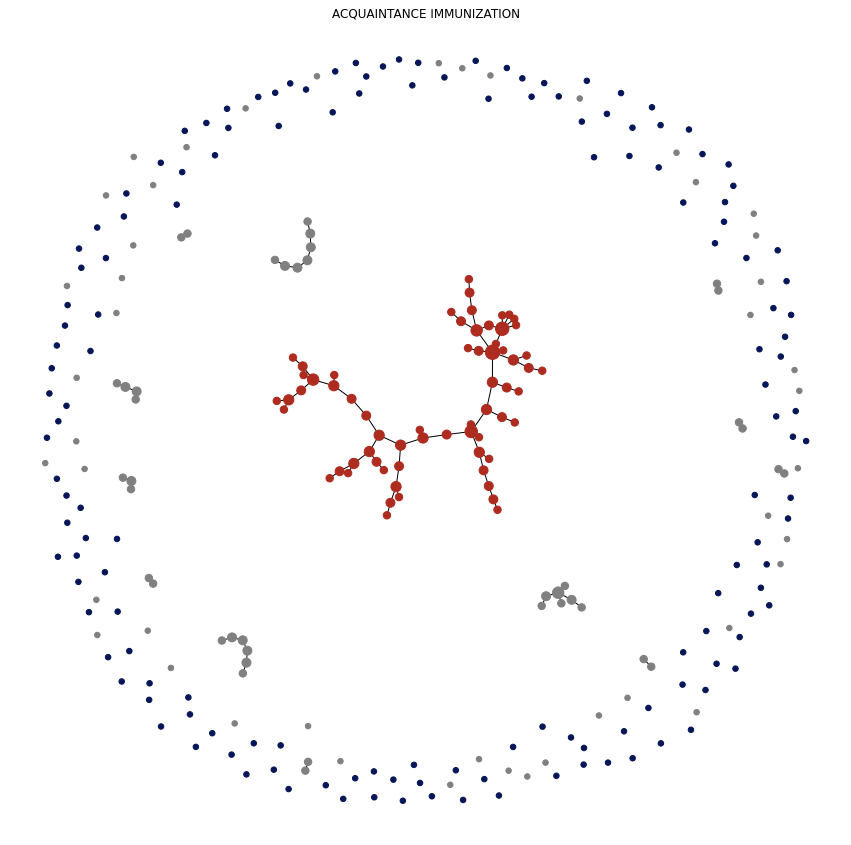

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

#Below, we define our parameters. N
#is just the number of agents in the network, while r
#
#is the percentage of the population that will be vaccinated.
#
N = 300
r = .5
G = nx.barabasi_albert_graph(N,3)

#For ease of plotting later, we write the viewnet() function.
print(f"RESULTS AFTER VACCINATING {r*100}% OF THE POPULATION")

def view_network(GG):
    colors = ['grey', '#051557', '#AE2B1F']
    GC_nodes = max(nx.connected_components(GG), key=len)
    GC = GG.subgraph(GC_nodes).copy()

    for n in GG.nodes():
        if n in list(GC_nodes):
            GG.nodes()[n]['col'] = 2
        else:
            GG.nodes()[n]['col'] = GG.nodes()[n]['vac']

    plt.figure(figsize=(15,15 ))
    pos = nx.spring_layout(GG)
    nx.draw_networkx_nodes(GG, pos=pos, nodelist=GG.nodes(), 
                           node_color=[colors[v] for v in list(nx.get_node_attributes(GG, 'col').values())],
                           node_size=[(v) * 25 + 30 for v in dict(GG.degree()).values()])
    nx.draw_networkx_edges(GG, pos=pos)
    plt.axis('off')
    return

#Randomly vaccinate r%
#of population.

G1 = G.copy()

vaccinate_them = np.random.choice(list(G1.nodes()), int(r*N), replace=False)  

for i in G1.nodes():
    if i in vaccinate_them:
        G1.nodes()[i]['vac'] = 1
    else:
        G1.nodes()[i]['vac'] = 0

G1.remove_edges_from(list(G1.edges(vaccinate_them)))

view_network(G1)
plt.title('RANDOM ATTACK')


#Vaccinate top r%
#of population in terms of connection.
#
G2 = G.copy()

top_n = int(r*N)

by_degree = sorted(G2.degree, key=lambda x: x[1], reverse=True)
vaccinate_them = [n for n, e in by_degree[:top_n]]

for i in G2.nodes():
    if i in vaccinate_them:
        G2.nodes()[i]['vac'] = 1
    else:
        G2.nodes()[i]['vac'] = 0

G2.remove_edges_from(list(G2.edges(vaccinate_them)))

view_network(G2)
plt.title('TARGET HUBS')


#Vaccinate a neighbor of randomly picked nodes - r%
#of the population.

G3 = G.copy()

for n in G3.nodes():
    G3.nodes()[n]['vac'] = 0

random_individuals = np.random.choice(list(G3.nodes()), int(r*N), replace=False)  
vaccinated_friend = []
for i in random_individuals:
    neighbors = list(G3.neighbors(i))
    unvac_neighbors = [n for n in neighbors if G3.nodes()[n]['vac'] == 0]
    if unvac_neighbors:
        picked = np.random.choice(unvac_neighbors, 1)[0]
        G3.nodes()[picked]['vac'] = 1
        vaccinated_friend.append(picked)

    # if all friends are vaccinated, vaccinate self
    elif G3.nodes()[i]['vac'] == 0:
        G3.nodes()[i]['vac'] = 1
        vaccinated_friend.append(i)

G3.remove_edges_from(list(G3.edges(vaccinated_friend)))

view_network(G3)
plt.title('ACQUAINTANCE IMMUNIZATION')




### Further reading

- Using network SIR-model to predict Parkinson's Disease atrophy
 - https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.3000495
 
- https://github.com/yingqiuz/SIR_simulator (Matlab)
- https://www.mdsabstracts.org/abstract/predicting-longitudinal-atrophy-in-parkinsons-disease-using-sir-model/
- https://arxiv.org/pdf/cond-mat/0207387.pdf
- https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.101.058701
